In [38]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

plt.close('all')
plt.rcParams['font.family']='serif'
plt.rcParams['font.serif']='Times New Roman'
plt.rcParams['font.size']=10
plt.rcParams['figure.dpi']=100

In [46]:
def create_model():
    model= {
        'dense1': tf.keras.layers.Dense(50,activation='tanh'),
        'dense2': tf.keras.layers.Dense(50,activation='tanh'),
        'dense3': tf.keras.layers.Dense(50,activation='tanh'),
        'output_layer': tf.keras.layers.Dense(1)
    }
    return model

In [47]:
def call_model(model,x):
    x =model['dense1'](x)
    x =model['dense2'](x)
    x =model['dense3'](x)
    x =model['output_layer'](x)
    return x

In [48]:
#Defining 2nd order pde
def pde(x,model):
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(x)
        y_pred=call_model(model,x)
        y_x=tape.gradient(y_pred,x)
    y_xx=tape.gradient(y_x,x)
    del tape
    return y_xx + np.pi**2 * tf.sin(np.pi * x)



In [50]:
def loss(model,x,x_bc,y_bc):
    res=pde(x,model)
    loss_pde=tf.reduce_mean(tf.square(res))
    y_bc_pred=call_model(model,x_bc)
    loss_bc=tf.reduce_mean(tf.square(y_bc - y_bc_pred))
    return loss_pde+loss_bc

In [52]:
def train_step(model,x,x_bc,y_bc,optimizer):
    with tf.GradientTape() as tape:
        loss_value=loss(model,x,x_bc,y_bc)
        grads=tape.gradient(loss_value,[layer.trainable_variables for layer in model.values()])
        #flatten the list of trainable parameters
        grads=[grad for sublist in grads for grad in sublist]
        variables=[var for layer in model.values() for var in layer.trainable_variables]
        optimizer.apply_gradients(zip(grads,variables))
        return loss_value

In [53]:
# Setting the problem

#Generating the training data
x_train=np.linspace(-1,1,100).reshape(-1,1)
x_train=tf.convert_to_tensor(x_train,dtype=tf.float32)

#Boundary data
x_bc=np.array([[-1.0],[1.0]], dtype=np.float32)
y_bc=np.array([[0.0],[0.0]], dtype=np.float32)
x_bc=tf.convert_to_tensor(x_bc,dtype=tf.float32)
y_bc=tf.convert_to_tensor(y_bc,dtype=tf.float32)

#Define the PINN model

model=create_model()

#Define the optimizer with a learning rate scheduler
lr_schedule=tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=1000,
    decay_rate=0.9
)
optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule)

#Train the model

epochs=2000
for epoch in range(epochs):
    loss_value=train_step(model,x_train,x_bc,y_bc,optimizer)
    if epoch % 100==0:
        print(f"Epoch{epoch}: Loss ={loss_value.numpy()}")


Epoch0: Loss =46.8403434753418
Epoch100: Loss =1.0631377696990967
Epoch200: Loss =0.04786969721317291
Epoch300: Loss =0.028486603870987892
Epoch400: Loss =0.015820978209376335
Epoch500: Loss =0.008823517709970474
Epoch600: Loss =0.005977274384349585
Epoch700: Loss =0.00429031765088439
Epoch800: Loss =0.0030291457660496235
Epoch900: Loss =0.0021337554790079594
Epoch1000: Loss =0.0015717009082436562
Epoch1100: Loss =0.0012500772718340158
Epoch1200: Loss =0.001063220202922821
Epoch1300: Loss =0.0009394611115567386
Epoch1400: Loss =0.0008425870910286903
Epoch1500: Loss =0.0008191894157789648
Epoch1600: Loss =0.0006794729270040989
Epoch1700: Loss =0.0006075093406252563
Epoch1800: Loss =0.0005385864060372114
Epoch1900: Loss =0.0004771347448695451


In [54]:
#Predict the solution

x_test=np.linspace(-1,1,1000).reshape(-1,1)
x_test=tf.convert_to_tensor(x_test,dtype=tf.float32)
y_pred=call_model(model,x_test).numpy()

#Analytical Solution

y_true=np.sin(np.pi*x_test)

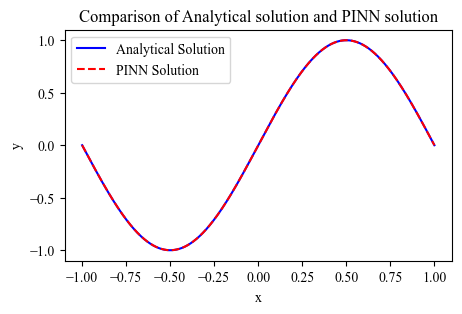

In [55]:
#Plot the results
plt.figure(figsize=(5,3))
plt.plot(x_test,y_true,'b-',label='Analytical Solution')
plt.plot(x_test,y_pred,'r--',label='PINN Solution')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.title("Comparison of Analytical solution and PINN solution")
plt.show()